In [ ]:
!pip install alpha_vantage tensorflow scikit-learn seaborn matplotlib --quiet


**with LSTM alone**

Enter stock ticker symbol (e.g., AAPL): AAPL
✅ Downloaded AAPL ticker data successfully from Alpha Vantage


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - loss: 0.0164 - val_loss: 5.0291e-04
Epoch 2/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0019 - val_loss: 6.0954e-04
Epoch 3/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - loss: 0.0015 - val_loss: 2.3406e-04
Epoch 4/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 0.0012 - val_loss: 2.7009e-04
Epoch 5/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0013 - val_loss: 3.0802e-04
Epoch 6/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0010 - val_loss: 1.3881e-04
Epoch 7/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0019 - val_loss: 1.2343e-04
Epoch 8/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.0011 - val_loss: 2.0804e-04
Epoch 9/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 0.0021 - val_loss: 1.4000e-04
Epoch 10/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0012 - val_loss: 1.2702e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


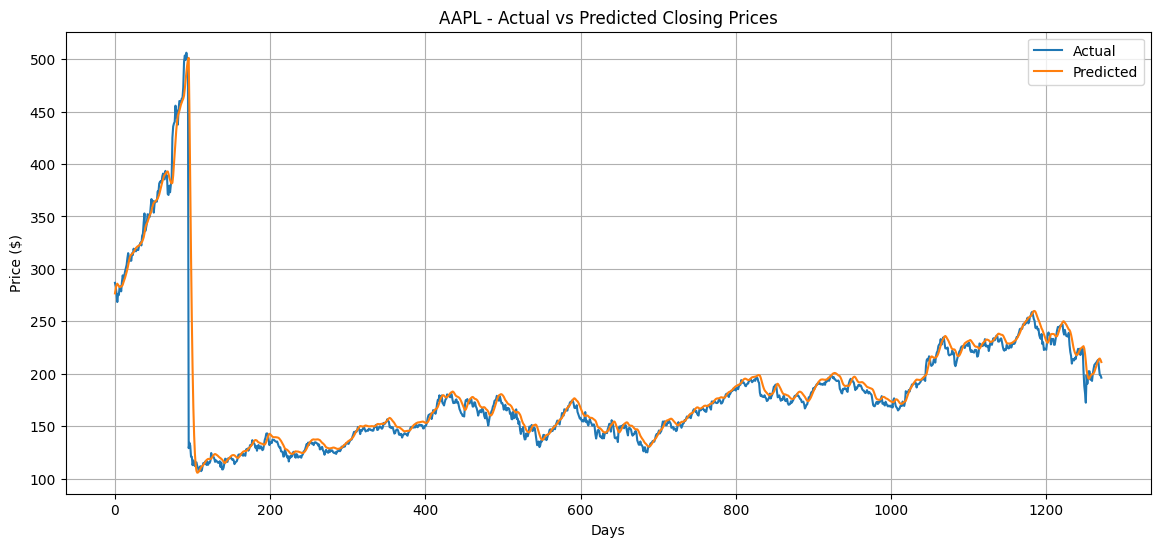

📉 Evaluation for AAPL
RMSE: 18.23
MAE : 5.96
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

📅 Predicted closing price for tomorrow: $208.67


In [ ]:
# ✅ Stock Price Prediction with Alpha Vantage API and LSTM (User Input + Visualization)

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime, timedelta

# 📥 Step 1: User Input
ticker = input("Enter stock ticker symbol (e.g., AAPL): ").upper()

# 📈 Step 2: Alpha Vantage API Setup (API Key required)
api_key = '5L2YFPQK698UM457'  # Replace with your actual Alpha Vantage API key
ts = TimeSeries(key=api_key, output_format='pandas')

# 📝 Step 3: Fetching Data from Alpha Vantage
def safe_download(ticker, retries=5, wait=10):
    for attempt in range(retries):
        try:
            data, meta_data = ts.get_daily(symbol=ticker, outputsize='full')
            print(f"✅ Downloaded {ticker} successfully from Alpha Vantage")
            return data['4. close']
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
        time.sleep(wait)
    raise ValueError(f"❌ Failed to download data for {ticker} after {retries} attempts.")

end_date = datetime.today()
start_date = end_date - timedelta(days=365 * 9)

# 📥 Get the closing price data from Alpha Vantage
data = safe_download(ticker)

# 🧹 Step 4: Preprocessing
data = data.sort_index(ascending=True)  # Sort by date (ascending)
data = data.dropna()  # Handle missing data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

# 🛠️ Step 5: Feature Engineering (Lagging)
look_back = 60
X, y = [], []
for i in range(look_back, len(scaled_data)):
    X.append(scaled_data[i - look_back:i])
    y.append(scaled_data[i])
X, y = np.array(X), np.array(y)

# 🧠 Step 6: Model Training
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1,
          callbacks=[EarlyStopping(monitor='val_loss', patience=3)], verbose=1)

# 🔮 Step 7: Predictions
predictions = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predictions)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# 📊 Step 8: Visualization
plt.figure(figsize=(14, 6))
plt.plot(real_prices, label='Actual')
plt.plot(predicted_prices, label='Predicted')
plt.title(f"{ticker} - Actual vs Predicted Closing Prices")
plt.xlabel("Days")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

# 📈 Step 9: Evaluation
rmse = np.sqrt(mean_squared_error(real_prices, predicted_prices))
mae = mean_absolute_error(real_prices, predicted_prices)
print(f"📉 Evaluation for {ticker}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")

# 🧾 Step 10: Next-Day Forecast
last_60 = scaled_data[-look_back:]
last_60 = np.reshape(last_60, (1, look_back, 1))
next_day_scaled = model.predict(last_60)
next_day_price = scaler.inverse_transform(next_day_scaled)[0][0]
print(f"\n📅 Predicted closing price for tomorrow: ${next_day_price:.2f}")


**with multiple models (proven linear regression the best)**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Enter stock ticker symbol (e.g., AAPL): AAPL
✅ Downloaded AAPL successfully from Alpha Vantage
Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 0.0211 - val_loss: 2.4981e-04
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0018 - val_loss: 2.3444e-04
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.0016 - val_loss: 1.7443e-04
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 0.0014 - val_loss: 1.8538e-04
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0015 - val_loss: 1.3317e-04
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.0012 - val_loss: 2.1713e-04
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0016 - val_loss: 3.0510e-04
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0011 - val_loss: 2.8457e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



📈 LSTM Evaluation
RMSE: 20.78
MAE : 9.04

📈 Linear Regression Evaluation
RMSE: 11.08
MAE : 2.84

📈 SVR Evaluation
RMSE: 29.97
MAE : 18.41

📈 Random Forest Evaluation
RMSE: 11.30
MAE : 3.18

🏆 Best model: Linear Regression with RMSE: 11.08 and MAE: 2.84


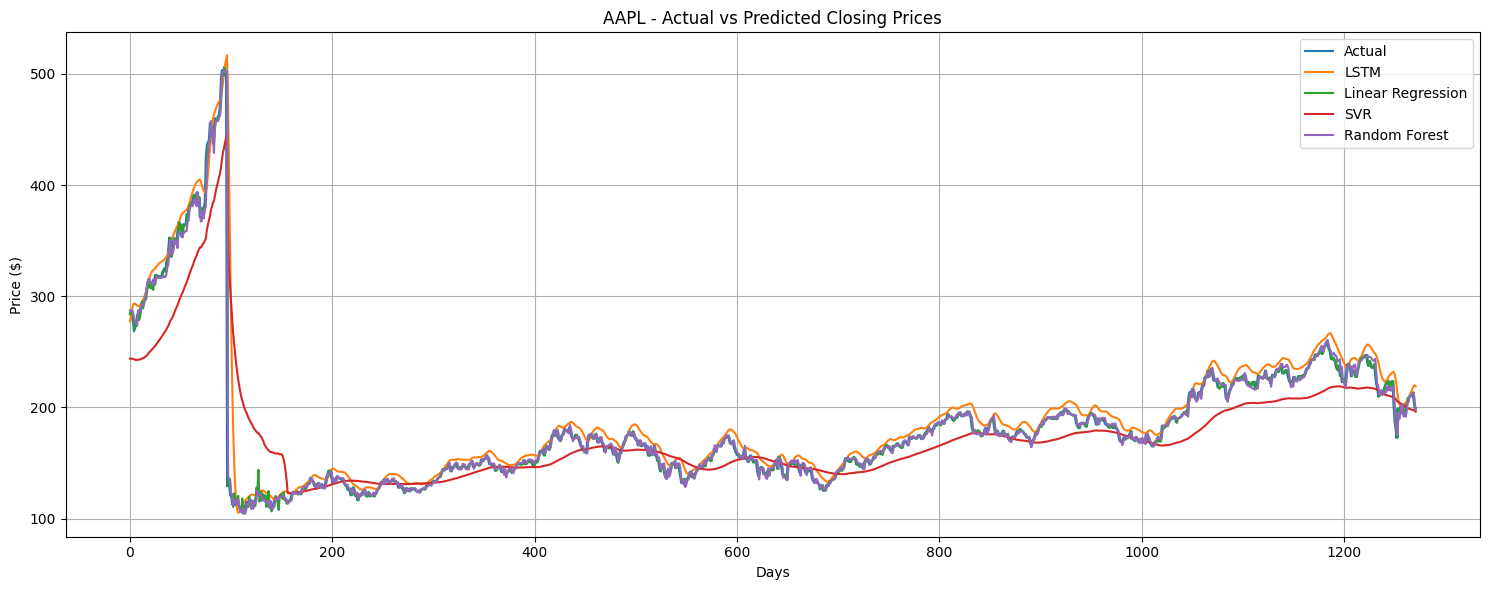

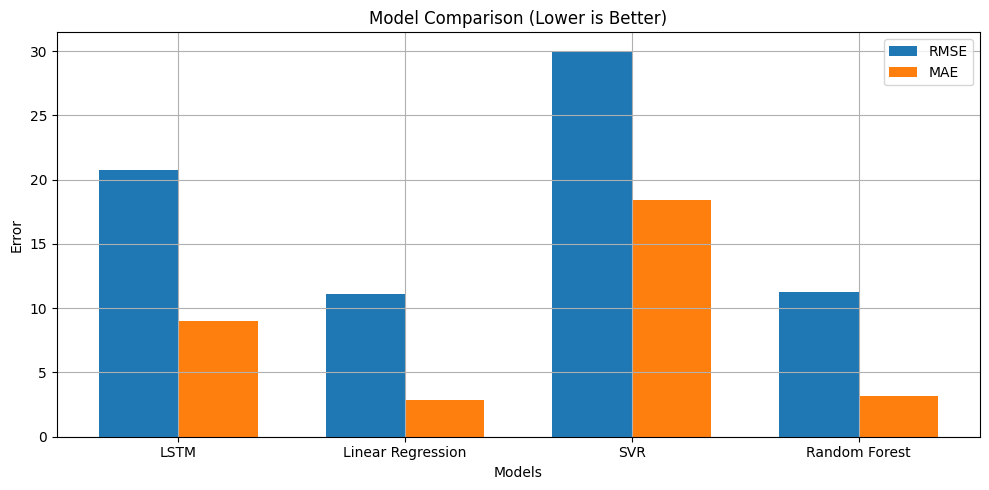


📅 Predicted closing price for tomorrow using Linear Regression: $198.61


In [ ]:
# ✅ Full Stock Price Prediction Script with Multiple Models (Enhanced Version)

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import joblib
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime, timedelta
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Directory setup for saving resources
base_dir = '/content/drive/MyDrive/Stock_Prediction'
os.makedirs(base_dir, exist_ok=True)

# Step 1: User Input
ticker = input("Enter stock ticker symbol (e.g., AAPL): ").upper()

# Step 2: Alpha Vantage API Setup
api_key = '5L2YFPQK698UM457'
ts = TimeSeries(key=api_key, output_format='pandas')

def safe_download(ticker, retries=5, wait=10):
    for attempt in range(retries):
        try:
            data, meta_data = ts.get_daily(symbol=ticker, outputsize='full')
            print(f"✅ Downloaded {ticker} successfully from Alpha Vantage")
            data.to_csv(os.path.join(base_dir, f"{ticker}_data.csv"))  # Save CSV to drive
            return data['4. close']
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
        time.sleep(wait)
    raise ValueError(f"❌ Failed to download data for {ticker} after {retries} attempts.")

# Step 3: Fetch data
data = safe_download(ticker)
end_date = datetime.today()
start_date = end_date - timedelta(days=365 * 9)

# Step 4: Preprocessing
data = data.sort_index(ascending=True)
data = data.dropna()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

# Step 5: Feature Engineering
look_back = 60
X, y = [], []
for i in range(look_back, len(scaled_data)):
    X.append(scaled_data[i - look_back:i])
    y.append(scaled_data[i])
X, y = np.array(X), np.array(y)

X_train, X_test = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
y_train, y_test = y[:int(0.8*len(y))], y[int(0.8*len(y)):]

# Step 6: LSTM Model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1,
               callbacks=[EarlyStopping(monitor='val_loss', patience=3)], verbose=1)

pred_lstm = lstm_model.predict(X_test)
pred_lstm_rescaled = scaler.inverse_transform(pred_lstm)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 7: Traditional ML Models require reshaping
X_ml = X.reshape(X.shape[0], -1)
X_train_ml, X_test_ml = X_ml[:int(0.8*len(X_ml))], X_ml[int(0.8*len(X_ml)):]

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_ml, y_train)
pred_lr = scaler.inverse_transform(lr.predict(X_test_ml).reshape(-1, 1))

# SVR
svr = SVR(kernel='rbf')
svr.fit(X_train_ml, y_train)
pred_svr = scaler.inverse_transform(svr.predict(X_test_ml).reshape(-1, 1))

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_ml, y_train)
pred_rf = scaler.inverse_transform(rf.predict(X_test_ml).reshape(-1, 1))

# Evaluation Function
def evaluate_model(name, actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    print(f"\n📈 {name} Evaluation")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    return name, rmse, mae

results = []
results.append(evaluate_model("LSTM", y_test_rescaled, pred_lstm_rescaled))
results.append(evaluate_model("Linear Regression", y_test_rescaled, pred_lr))
results.append(evaluate_model("SVR", y_test_rescaled, pred_svr))
results.append(evaluate_model("Random Forest", y_test_rescaled, pred_rf))

# Find best model
best_model = sorted(results, key=lambda x: x[1])[0]  # lowest RMSE
print(f"\n🏆 Best model: {best_model[0]} with RMSE: {best_model[1]:.2f} and MAE: {best_model[2]:.2f}")

# Visualization
plt.figure(figsize=(15, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(pred_lstm_rescaled, label='LSTM')
plt.plot(pred_lr, label='Linear Regression')
plt.plot(pred_svr, label='SVR')
plt.plot(pred_rf, label='Random Forest')
plt.title(f"{ticker} - Actual vs Predicted Closing Prices")
plt.xlabel("Days")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(base_dir, f"{ticker}_all_model_comparison.png"))
plt.show()

# Bar Chart Comparison
model_names = [r[0] for r in results]
rmse_scores = [r[1] for r in results]
mae_scores = [r[2] for r in results]

plt.figure(figsize=(10, 5))
bar_width = 0.35
index = np.arange(len(model_names))
plt.bar(index, rmse_scores, bar_width, label='RMSE')
plt.bar(index + bar_width, mae_scores, bar_width, label='MAE')
plt.xlabel('Models')
plt.ylabel('Error')
plt.title('Model Comparison (Lower is Better)')
plt.xticks(index + bar_width / 2, model_names)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(base_dir, f"{ticker}_error_bar_chart.png"))
plt.show()

# Next-Day Forecast with Best Model
if best_model[0] == "LSTM":
    last_60 = scaled_data[-look_back:].reshape(1, look_back, 1)
    next_day_pred = lstm_model.predict(last_60)
    next_day_price = scaler.inverse_transform(next_day_pred)[0][0]
elif best_model[0] == "Linear Regression":
    last_60 = scaled_data[-look_back:].reshape(1, -1)
    next_day_price = scaler.inverse_transform(lr.predict(last_60).reshape(-1, 1))[0][0]
elif best_model[0] == "SVR":
    last_60 = scaled_data[-look_back:].reshape(1, -1)
    next_day_price = scaler.inverse_transform(svr.predict(last_60).reshape(-1, 1))[0][0]
elif best_model[0] == "Random Forest":
    last_60 = scaled_data[-look_back:].reshape(1, -1)
    next_day_price = scaler.inverse_transform(rf.predict(last_60).reshape(-1, 1))[0][0]

print(f"\n📅 Predicted closing price for tomorrow using {best_model[0]}: ${next_day_price:.2f}")


yfinance

In [ ]:
# ✅ Full Stock Price Prediction Script with Multiple Models (Enhanced Version)

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import joblib
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime, timedelta
from google.colab import drive
import yfinance as yf

# Mount Google Drive
drive.mount('/content/drive')

# Directory setup for saving resources
base_dir = '/content/drive/MyDrive/Stock_Prediction_yfinance'
os.makedirs(base_dir, exist_ok=True)

# Step 1: User Input
ticker = input("Enter stock ticker symbol (e.g., AAPL): ").upper()

# Step 2: Yahoo Finance Data Fetching

def safe_download(ticker):
    try:
        data = yf.download(ticker, start=(datetime.today() - timedelta(days=365*9)).strftime('%Y-%m-%d'))
        if data.empty:
            raise ValueError("No data downloaded.")
        print(f"✅ Downloaded {ticker} successfully from Yahoo Finance")
        data.to_csv(os.path.join(base_dir, f"{ticker}_data.csv"))
        return data['Close']
    except Exception as e:
        raise ValueError(f"❌ Failed to download data for {ticker}: {e}")

# Step 3: Fetch data
data = safe_download(ticker)
end_date = datetime.today()
start_date = end_date - timedelta(days=365 * 9)

# Step 4: Preprocessing
data = data.sort_index(ascending=True)
data = data.dropna()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

# Step 5: Feature Engineering
look_back = 60
X, y = [], []
for i in range(look_back, len(scaled_data)):
    X.append(scaled_data[i - look_back:i])
    y.append(scaled_data[i])
X, y = np.array(X), np.array(y)

X_train, X_test = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
y_train, y_test = y[:int(0.8*len(y))], y[int(0.8*len(y)):]

# Step 6: LSTM Model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1,
               callbacks=[EarlyStopping(monitor='val_loss', patience=3)], verbose=1)

pred_lstm = lstm_model.predict(X_test)
pred_lstm_rescaled = scaler.inverse_transform(pred_lstm)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 7: Traditional ML Models require reshaping
X_ml = X.reshape(X.shape[0], -1)
X_train_ml, X_test_ml = X_ml[:int(0.8*len(X_ml))], X_ml[int(0.8*len(X_ml)):]

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_ml, y_train)
pred_lr = scaler.inverse_transform(lr.predict(X_test_ml).reshape(-1, 1))

# SVR
svr = SVR(kernel='rbf')
svr.fit(X_train_ml, y_train)
pred_svr = scaler.inverse_transform(svr.predict(X_test_ml).reshape(-1, 1))

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_ml, y_train)
pred_rf = scaler.inverse_transform(rf.predict(X_test_ml).reshape(-1, 1))

# Evaluation Function
def evaluate_model(name, actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    print(f"\n📈 {name} Evaluation")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    return name, rmse, mae

results = []
results.append(evaluate_model("LSTM", y_test_rescaled, pred_lstm_rescaled))
results.append(evaluate_model("Linear Regression", y_test_rescaled, pred_lr))
results.append(evaluate_model("SVR", y_test_rescaled, pred_svr))
results.append(evaluate_model("Random Forest", y_test_rescaled, pred_rf))

# Find best model
best_model = sorted(results, key=lambda x: x[1])[0]  # lowest RMSE
print(f"\n🏆 Best model: {best_model[0]} with RMSE: {best_model[1]:.2f} and MAE: {best_model[2]:.2f}")

# Visualization
plt.figure(figsize=(15, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(pred_lstm_rescaled, label='LSTM')
plt.plot(pred_lr, label='Linear Regression')
plt.plot(pred_svr, label='SVR')
plt.plot(pred_rf, label='Random Forest')
plt.title(f"{ticker} - Actual vs Predicted Closing Prices")
plt.xlabel("Days")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(base_dir, f"{ticker}_all_model_comparison.png"))
plt.show()

# Bar Chart Comparison
model_names = [r[0] for r in results]
rmse_scores = [r[1] for r in results]
mae_scores = [r[2] for r in results]

plt.figure(figsize=(10, 5))
bar_width = 0.35
index = np.arange(len(model_names))
plt.bar(index, rmse_scores, bar_width, label='RMSE')
plt.bar(index + bar_width, mae_scores, bar_width, label='MAE')
plt.xlabel('Models')
plt.ylabel('Error')
plt.title('Model Comparison (Lower is Better)')
plt.xticks(index + bar_width / 2, model_names)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(base_dir, f"{ticker}_error_bar_chart.png"))
plt.show()

# Next-Day Forecast with Best Model
if best_model[0] == "LSTM":
    last_60 = scaled_data[-look_back:].reshape(1, look_back, 1)
    next_day_pred = lstm_model.predict(last_60)
    next_day_price = scaler.inverse_transform(next_day_pred)[0][0]
elif best_model[0] == "Linear Regression":
    last_60 = scaled_data[-look_back:].reshape(1, -1)
    next_day_price = scaler.inverse_transform(lr.predict(last_60).reshape(-1, 1))[0][0]
elif best_model[0] == "SVR":
    last_60 = scaled_data[-look_back:].reshape(1, -1)
    next_day_price = scaler.inverse_transform(svr.predict(last_60).reshape(-1, 1))[0][0]
elif best_model[0] == "Random Forest":
    last_60 = scaled_data[-look_back:].reshape(1, -1)
    next_day_price = scaler.inverse_transform(rf.predict(last_60).reshape(-1, 1))[0][0]

print(f"\n📅 Predicted closing price for tomorrow using {best_model[0]}: ${next_day_price:.2f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Enter stock ticker symbol (e.g., AAPL): AAPL


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


ValueError: ❌ Failed to download data for AAPL: No data downloaded.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Enter stock ticker symbol (e.g., AAPL): AAPL
✅ Downloaded AAPL successfully from Alpha Vantage
Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0138 - val_loss: 3.3777e-04
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0018 - val_loss: 1.8644e-04
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 0.0015 - val_loss: 1.5439e-04
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.0014 - val_loss: 1.2958e-04
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0012 - val_loss: 2.2117e-04
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.0012 - val_loss: 2.2857e-04
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 0.0014 - val_loss: 1.7013e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



📈 LSTM Evaluation
RMSE: 19.13
MAE : 6.90

📈 Linear Regression Evaluation
RMSE: 11.08
MAE : 2.84

📈 SVR Evaluation
RMSE: 29.97
MAE : 18.41

📈 Random Forest Evaluation
RMSE: 11.30
MAE : 3.18

🏆 Best model: Linear Regression with RMSE: 11.08 and MAE: 2.84


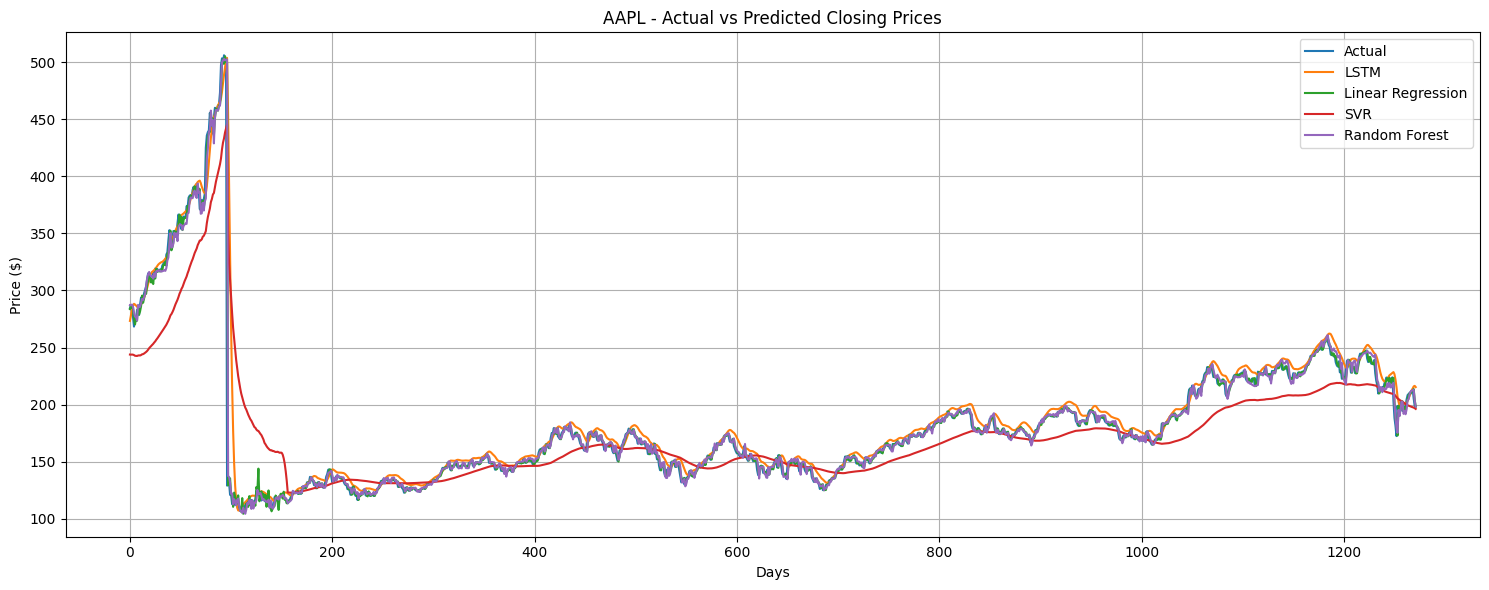

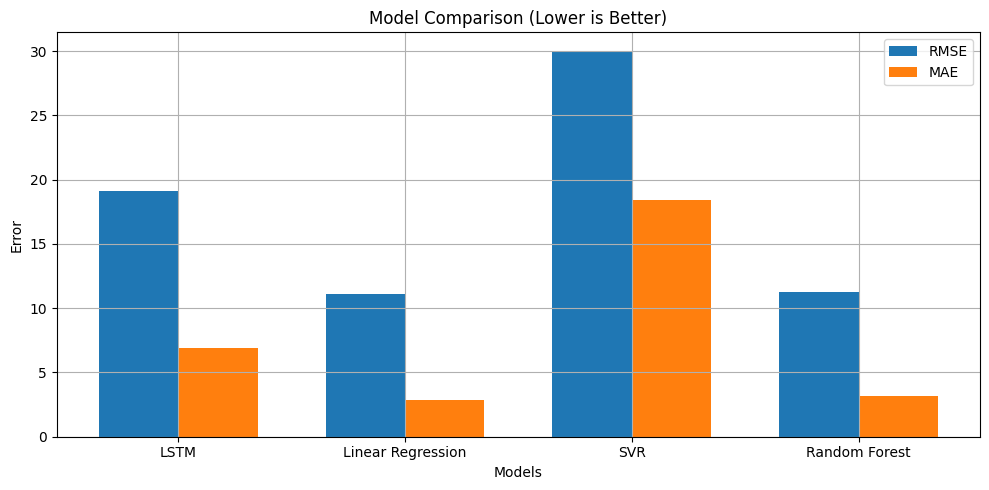


📅 Predicted closing price for tomorrow using Linear Regression: $198.61


In [ ]:
# ✅ Full Stock Price Prediction Script with Multiple Models (Enhanced Version)

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import joblib
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime, timedelta
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Directory setup for saving resources
base_dir = '/content/drive/MyDrive/Stock_Prediction_YF'
os.makedirs(base_dir, exist_ok=True)

# Step 1: User Input
ticker = input("Enter stock ticker symbol (e.g., AAPL): ").upper()

# Step 2: Alpha Vantage API Setup
api_key = '5L2YFPQK698UM457'
ts = TimeSeries(key=api_key, output_format='pandas')

def safe_download(ticker, retries=5, wait=10):
    for attempt in range(retries):
        try:
            data, meta_data = ts.get_daily(symbol=ticker, outputsize='full')
            data = data[['4. close']]  # Keep only the '4. close' column
            data.columns = ['close']   # Rename for simplicity
            data = data.sort_index(ascending=True)
            data.dropna(inplace=True)
            print(f"✅ Downloaded {ticker} successfully from Alpha Vantage")
            data.to_csv(os.path.join(base_dir, f"{ticker}_data.csv"))  # Save CSV to drive
            return data
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
        time.sleep(wait)
    raise ValueError(f"❌ Failed to download data for {ticker} after {retries} attempts.")

# Step 3: Fetch data
data_df = safe_download(ticker)
data = data_df['close']  # Use only the 'close' column, which is numeric
end_date = datetime.today()
start_date = end_date - timedelta(days=365 * 9)

# Step 4: Preprocessing
data = data.sort_index(ascending=True)
data = data.dropna()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

# Step 5: Feature Engineering
look_back = 60
X, y = [], []
for i in range(look_back, len(scaled_data)):
    X.append(scaled_data[i - look_back:i])
    y.append(scaled_data[i])
X, y = np.array(X), np.array(y)

X_train, X_test = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
y_train, y_test = y[:int(0.8*len(y))], y[int(0.8*len(y)):]

# Step 6: LSTM Model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1,
               callbacks=[EarlyStopping(monitor='val_loss', patience=3)], verbose=1)

pred_lstm = lstm_model.predict(X_test)
pred_lstm_rescaled = scaler.inverse_transform(pred_lstm)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 7: Traditional ML Models require reshaping
X_ml = X.reshape(X.shape[0], -1)
X_train_ml, X_test_ml = X_ml[:int(0.8*len(X_ml))], X_ml[int(0.8*len(X_ml)):]

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_ml, y_train)
pred_lr = scaler.inverse_transform(lr.predict(X_test_ml).reshape(-1, 1))

# SVR
svr = SVR(kernel='rbf')
svr.fit(X_train_ml, y_train)
pred_svr = scaler.inverse_transform(svr.predict(X_test_ml).reshape(-1, 1))

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_ml, y_train)
pred_rf = scaler.inverse_transform(rf.predict(X_test_ml).reshape(-1, 1))

# Evaluation Function
def evaluate_model(name, actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    print(f"\n📈 {name} Evaluation")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    return name, rmse, mae

results = []
results.append(evaluate_model("LSTM", y_test_rescaled, pred_lstm_rescaled))
results.append(evaluate_model("Linear Regression", y_test_rescaled, pred_lr))
results.append(evaluate_model("SVR", y_test_rescaled, pred_svr))
results.append(evaluate_model("Random Forest", y_test_rescaled, pred_rf))

# Find best model
best_model = sorted(results, key=lambda x: x[1])[0]  # lowest RMSE
print(f"\n🏆 Best model: {best_model[0]} with RMSE: {best_model[1]:.2f} and MAE: {best_model[2]:.2f}")

# Visualization
plt.figure(figsize=(15, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(pred_lstm_rescaled, label='LSTM')
plt.plot(pred_lr, label='Linear Regression')
plt.plot(pred_svr, label='SVR')
plt.plot(pred_rf, label='Random Forest')
plt.title(f"{ticker} - Actual vs Predicted Closing Prices")
plt.xlabel("Days")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(base_dir, f"{ticker}_all_model_comparison.png"))
plt.show()

# Bar Chart Comparison
model_names = [r[0] for r in results]
rmse_scores = [r[1] for r in results]
mae_scores = [r[2] for r in results]

plt.figure(figsize=(10, 5))
bar_width = 0.35
index = np.arange(len(model_names))
plt.bar(index, rmse_scores, bar_width, label='RMSE')
plt.bar(index + bar_width, mae_scores, bar_width, label='MAE')
plt.xlabel('Models')
plt.ylabel('Error')
plt.title('Model Comparison (Lower is Better)')
plt.xticks(index + bar_width / 2, model_names)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(base_dir, f"{ticker}_error_bar_chart.png"))
plt.show()

# Next-Day Forecast with Best Model
if best_model[0] == "LSTM":
    last_60 = scaled_data[-look_back:].reshape(1, look_back, 1)
    next_day_pred = lstm_model.predict(last_60)
    next_day_price = scaler.inverse_transform(next_day_pred)[0][0]
elif best_model[0] == "Linear Regression":
    last_60 = scaled_data[-look_back:].reshape(1, -1)
    next_day_price = scaler.inverse_transform(lr.predict(last_60).reshape(-1, 1))[0][0]
elif best_model[0] == "SVR":
    last_60 = scaled_data[-look_back:].reshape(1, -1)
    next_day_price = scaler.inverse_transform(svr.predict(last_60).reshape(-1, 1))[0][0]
elif best_model[0] == "Random Forest":
    last_60 = scaled_data[-look_back:].reshape(1, -1)
    next_day_price = scaler.inverse_transform(rf.predict(last_60).reshape(-1, 1))[0][0]

print(f"\n📅 Predicted closing price for tomorrow using {best_model[0]}: ${next_day_price:.2f}")


with efficiency

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Enter stock ticker symbol (e.g., AAPL): AAPL
✅ Downloaded AAPL successfully from Alpha Vantage
Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 0.0186 - val_loss: 3.6631e-04
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0022 - val_loss: 1.9236e-04
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.0019 - val_loss: 2.8774e-04
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 0.0013 - val_loss: 1.7065e-04
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0016 - val_loss: 2.1094e-04
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 0.0012 - val_loss: 1.2255e-04
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0010 - val_loss: 2.7263e-04
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 9.6668e-04 - val_loss: 1.6903e-04
Epoch 9/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0013 - val_loss: 2.1312e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



📈 LSTM Evaluation
RMSE: 19.98
MAE : 9.66
R²  : 0.90

📈 Linear Regression Evaluation
RMSE: 11.08
MAE : 2.84
R²  : 0.97

📈 SVR Evaluation
RMSE: 29.97
MAE : 18.41
R²  : 0.78

📈 Random Forest Evaluation
RMSE: 11.30
MAE : 3.18
R²  : 0.97

🏆 Best model: Linear Regression with RMSE: 11.08 and MAE: 2.84 and R²: 0.97


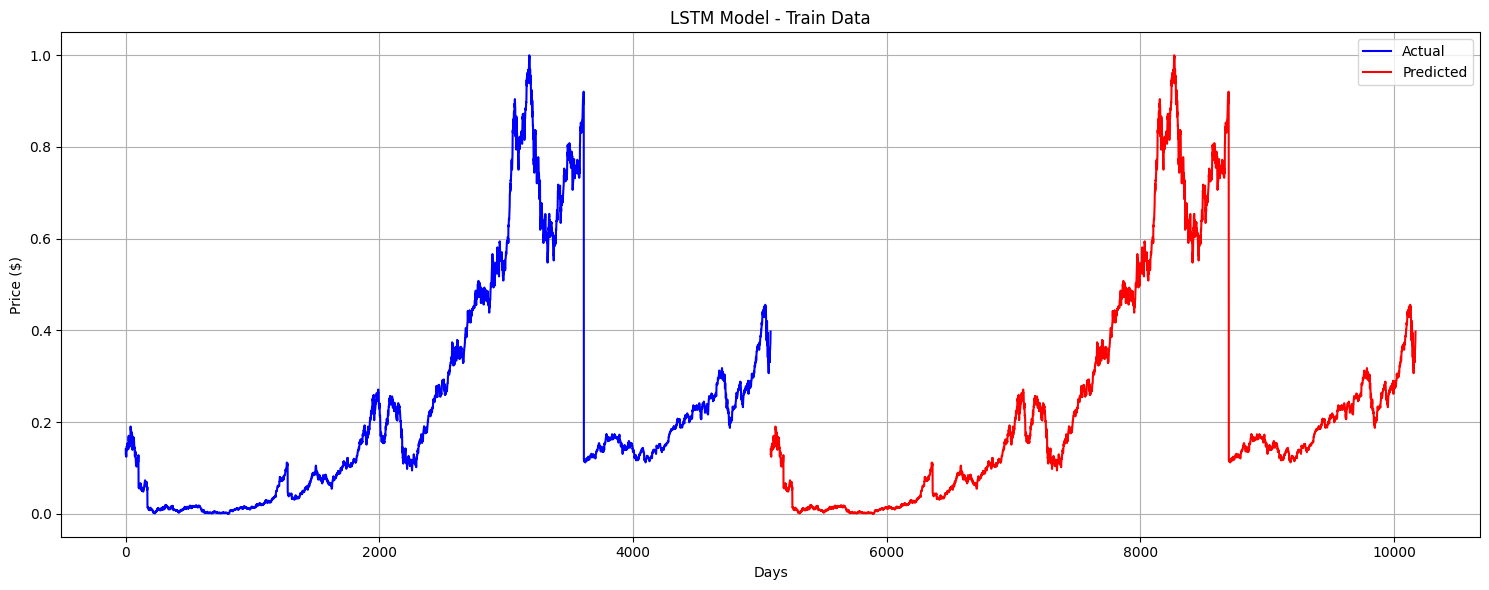

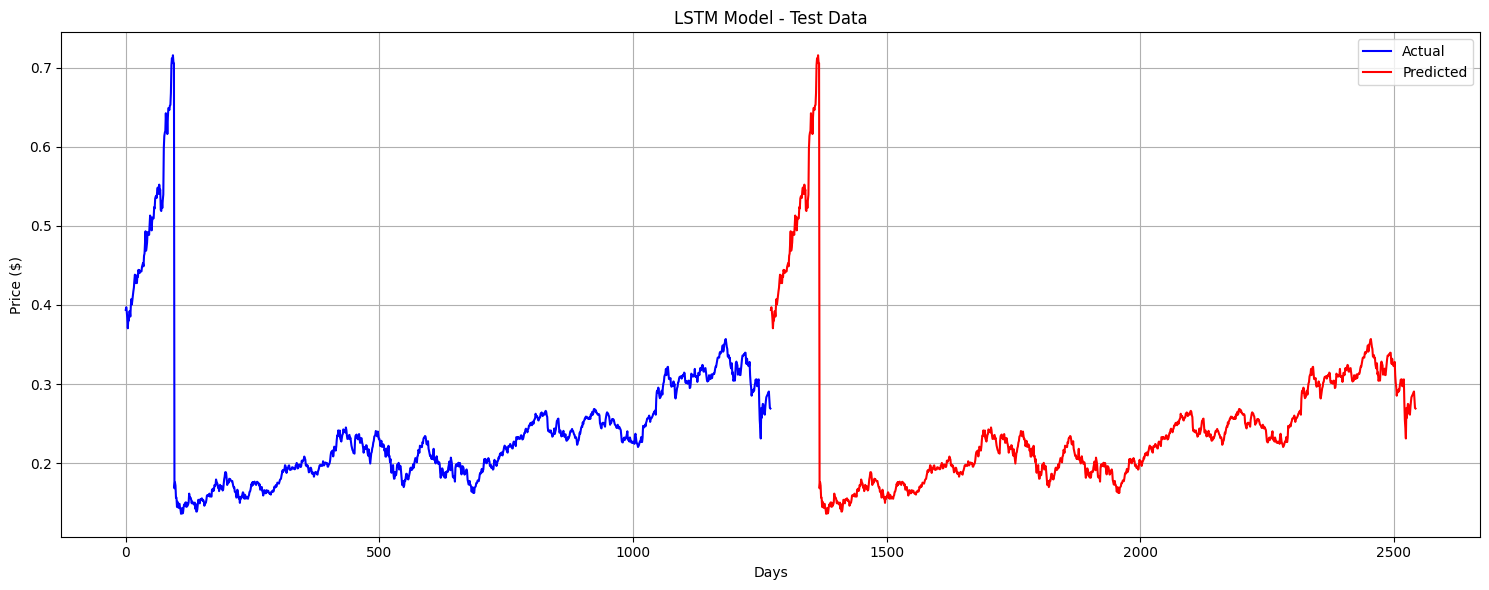

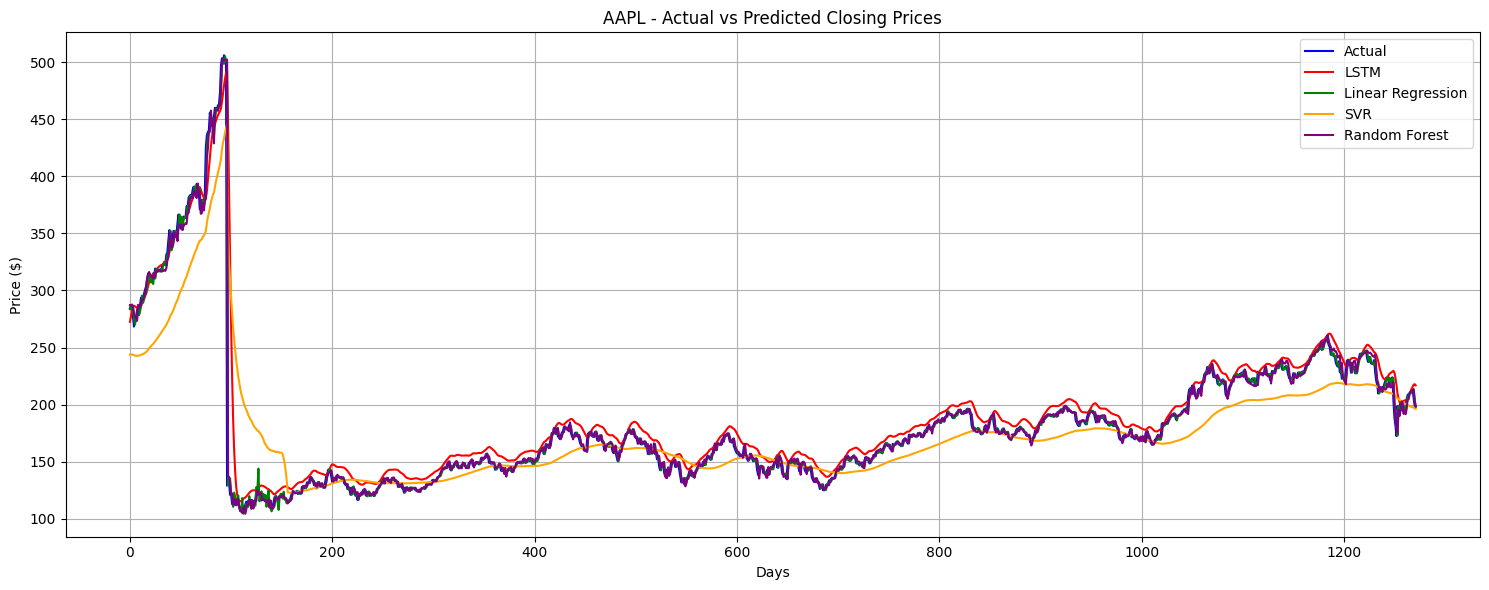

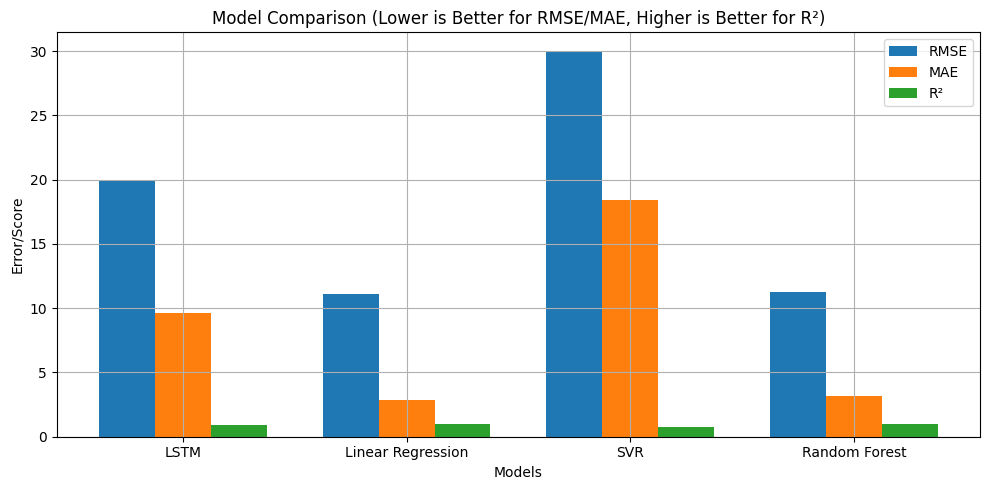


📅 Predicted closing price for tomorrow using Linear Regression: $198.61


In [ ]:
# ✅ Full Stock Price Prediction Script with Multiple Models (Enhanced Version)

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import joblib
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime, timedelta
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Directory setup for saving resources
base_dir = '/content/drive/MyDrive/Stock_Prediction'
os.makedirs(base_dir, exist_ok=True)

# Step 1: User Input
ticker = input("Enter stock ticker symbol (e.g., AAPL): ").upper()

# Step 2: Alpha Vantage API Setup
api_key = '5L2YFPQK698UM457'
ts = TimeSeries(key=api_key, output_format='pandas')

def safe_download(ticker, retries=5, wait=10):
    for attempt in range(retries):
        try:
            data, meta_data = ts.get_daily(symbol=ticker, outputsize='full')
            data = data[['4. close']]  # Keep only the '4. close' column
            data.columns = ['close']   # Rename for simplicity
            data = data.sort_index(ascending=True)
            data.dropna(inplace=True)
            print(f"✅ Downloaded {ticker} successfully from Alpha Vantage")
            data.to_csv(os.path.join(base_dir, f"{ticker}_data.csv"))  # Save CSV to drive
            return data
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
        time.sleep(wait)
    raise ValueError(f"❌ Failed to download data for {ticker} after {retries} attempts.")

# Step 3: Fetch data
data_df = safe_download(ticker)
data = data_df['close']  # Use only the 'close' column, which is numeric
end_date = datetime.today()
start_date = end_date - timedelta(days=365 * 9)

# Step 4: Preprocessing
data = data.sort_index(ascending=True)
data = data.dropna()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

# Step 5: Feature Engineering
look_back = 60
X, y = [], []
for i in range(look_back, len(scaled_data)):
    X.append(scaled_data[i - look_back:i])
    y.append(scaled_data[i])
X, y = np.array(X), np.array(y)

X_train, X_test = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
y_train, y_test = y[:int(0.8*len(y))], y[int(0.8*len(y)):]

# Step 6: LSTM Model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1,
               callbacks=[EarlyStopping(monitor='val_loss', patience=3)], verbose=1)

pred_lstm = lstm_model.predict(X_test)
pred_lstm_rescaled = scaler.inverse_transform(pred_lstm)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 7: Traditional ML Models require reshaping
X_ml = X.reshape(X.shape[0], -1)
X_train_ml, X_test_ml = X_ml[:int(0.8*len(X_ml))], X_ml[int(0.8*len(X_ml)):]

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_ml, y_train)
pred_lr = scaler.inverse_transform(lr.predict(X_test_ml).reshape(-1, 1))

# SVR
svr = SVR(kernel='rbf')
svr.fit(X_train_ml, y_train)
pred_svr = scaler.inverse_transform(svr.predict(X_test_ml).reshape(-1, 1))

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_ml, y_train)
pred_rf = scaler.inverse_transform(rf.predict(X_test_ml).reshape(-1, 1))

# Evaluation Function
def evaluate_model(name, actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    print(f"\n📈 {name} Evaluation")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"R²  : {r2:.2f}")
    return name, rmse, mae, r2

results = []
results.append(evaluate_model("LSTM", y_test_rescaled, pred_lstm_rescaled))
results.append(evaluate_model("Linear Regression", y_test_rescaled, pred_lr))
results.append(evaluate_model("SVR", y_test_rescaled, pred_svr))
results.append(evaluate_model("Random Forest", y_test_rescaled, pred_rf))

# Find best model
best_model = sorted(results, key=lambda x: x[1])[0]  # lowest RMSE
print(f"\n🏆 Best model: {best_model[0]} with RMSE: {best_model[1]:.2f} and MAE: {best_model[2]:.2f} and R²: {best_model[3]:.2f}")

# Visualization - Train/Test Data Graphs
def plot_data(X, y, title, filename):
    plt.figure(figsize=(15, 6))
    plt.plot(y, label='Actual', color='blue')
    plt.plot(range(len(X), len(X) + len(y)), y, label='Predicted', color='red')
    plt.title(title)
    plt.xlabel("Days")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, filename))
    plt.show()

plot_data(X_train, y_train, "LSTM Model - Train Data", f"{ticker}_train_data_lstm.png")
plot_data(X_test, y_test, "LSTM Model - Test Data", f"{ticker}_test_data_lstm.png")

# Comparison Visualization
plt.figure(figsize=(15, 6))
plt.plot(y_test_rescaled, label='Actual', color='blue')
plt.plot(pred_lstm_rescaled, label='LSTM', color='red')
plt.plot(pred_lr, label='Linear Regression', color='green')
plt.plot(pred_svr, label='SVR', color='orange')
plt.plot(pred_rf, label='Random Forest', color='purple')
plt.title(f"{ticker} - Actual vs Predicted Closing Prices")
plt.xlabel("Days")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(base_dir, f"{ticker}_all_model_comparison.png"))
plt.show()

# Bar Chart Comparison
model_names = [r[0] for r in results]
rmse_scores = [r[1] for r in results]
mae_scores = [r[2] for r in results]
r2_scores = [r[3] for r in results]

plt.figure(figsize=(10, 5))
bar_width = 0.25
index = np.arange(len(model_names))
plt.bar(index, rmse_scores, bar_width, label='RMSE')
plt.bar(index + bar_width, mae_scores, bar_width, label='MAE')
plt.bar(index + 2 * bar_width, r2_scores, bar_width, label='R²')
plt.xlabel('Models')
plt.ylabel('Error/Score')
plt.title('Model Comparison (Lower is Better for RMSE/MAE, Higher is Better for R²)')
plt.xticks(index + bar_width, model_names)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(base_dir, f"{ticker}_error_score_comparison.png"))
plt.show()

# Next-Day Forecast with Best Model
if best_model[0] == "LSTM":
    last_60 = scaled_data[-look_back:].reshape(1, look_back, 1)
    next_day_pred = lstm_model.predict(last_60)
    next_day_price = scaler.inverse_transform(next_day_pred)[0][0]
elif best_model[0] == "Linear Regression":
    last_60 = scaled_data[-look_back:].reshape(1, -1)
    next_day_price = scaler.inverse_transform(lr.predict(last_60).reshape(-1, 1))[0][0]
elif best_model[0] == "SVR":
    last_60 = scaled_data[-look_back:].reshape(1, -1)
    next_day_price = scaler.inverse_transform(svr.predict(last_60).reshape(-1, 1))[0][0]
elif best_model[0] == "Random Forest":
    last_60 = scaled_data[-look_back:].reshape(1, -1)
    next_day_price = scaler.inverse_transform(rf.predict(last_60).reshape(-1, 1))[0][0]

print(f"\n📅 Predicted closing price for tomorrow using {best_model[0]}: ${next_day_price:.2f}")


with all other models too be part in the plot

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Enter stock ticker symbol (e.g., AAPL): AAPL
✅ Downloaded AAPL successfully from Alpha Vantage


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 0.0118 - val_loss: 2.1726e-04
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0021 - val_loss: 7.0223e-04
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0016 - val_loss: 3.5165e-04
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0017 - val_loss: 1.4626e-04
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.0018 - val_loss: 2.5258e-04
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.0012 - val_loss: 1.2539e-04
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 0.0011 - val_loss: 1.1209e-04
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 0.0015 - val_loss: 1.3294e-04
Epoch 9/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.0011 - val_loss: 1.1063e-04
Epoch 10/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 9.3744e-04 - val_loss: 1.1149e-04
Epoch 11/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.0014 - val_loss: 1

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



📈 LSTM Evaluation
RMSE: 17.03
MAE : 7.74

📈 Linear Regression Evaluation
RMSE: 11.08
MAE : 2.84

📈 SVR Evaluation
RMSE: 29.97
MAE : 18.41

📈 Random Forest Evaluation
RMSE: 11.30
MAE : 3.18

🏆 Best model: Linear Regression with RMSE: 11.08 and MAE: 2.84


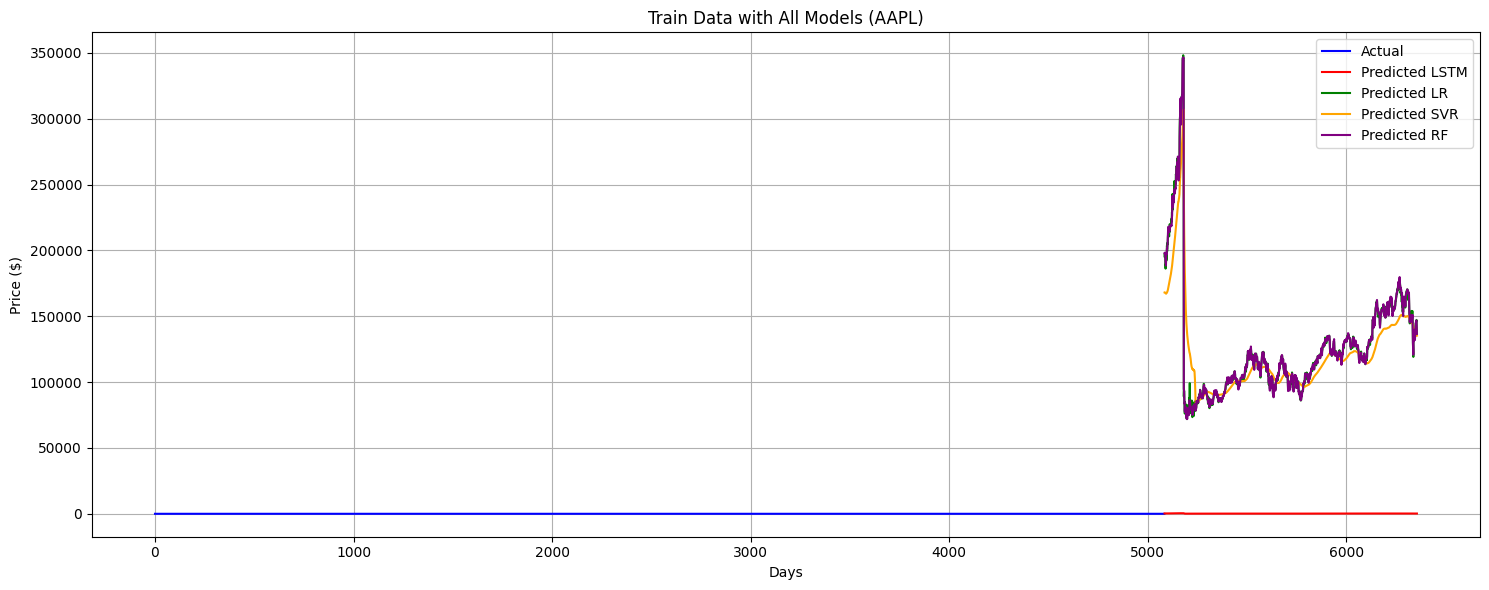

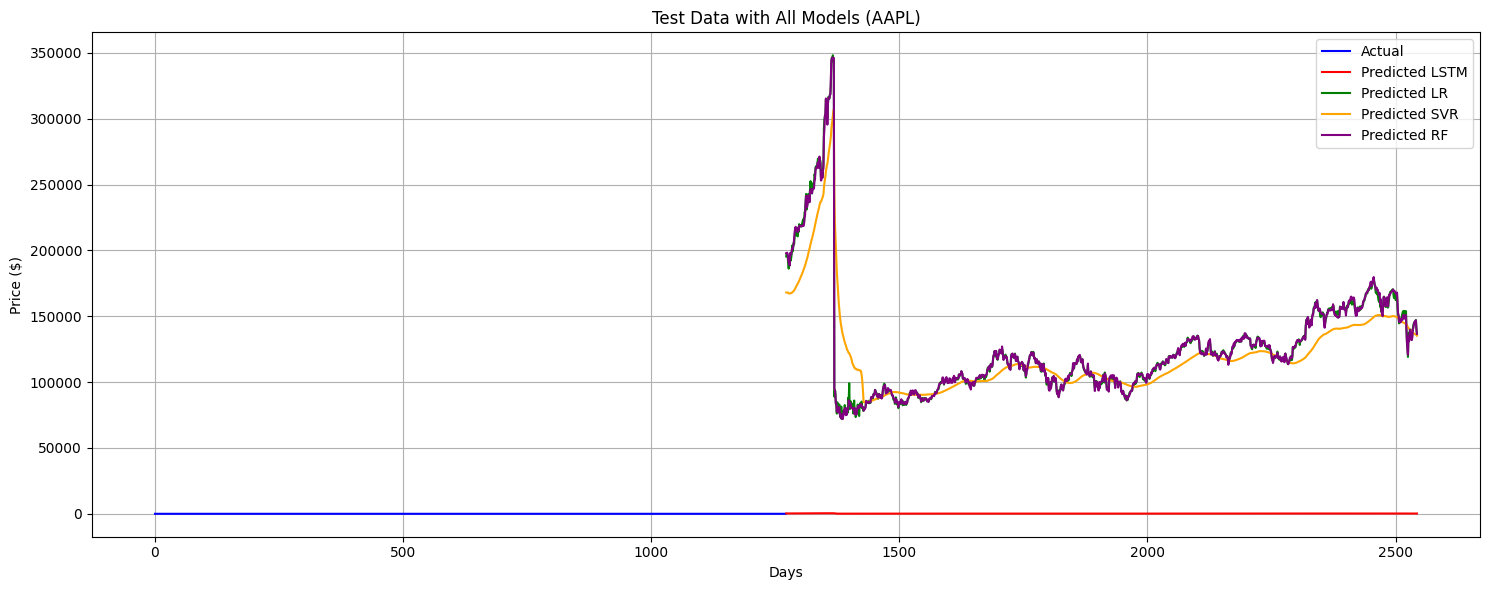

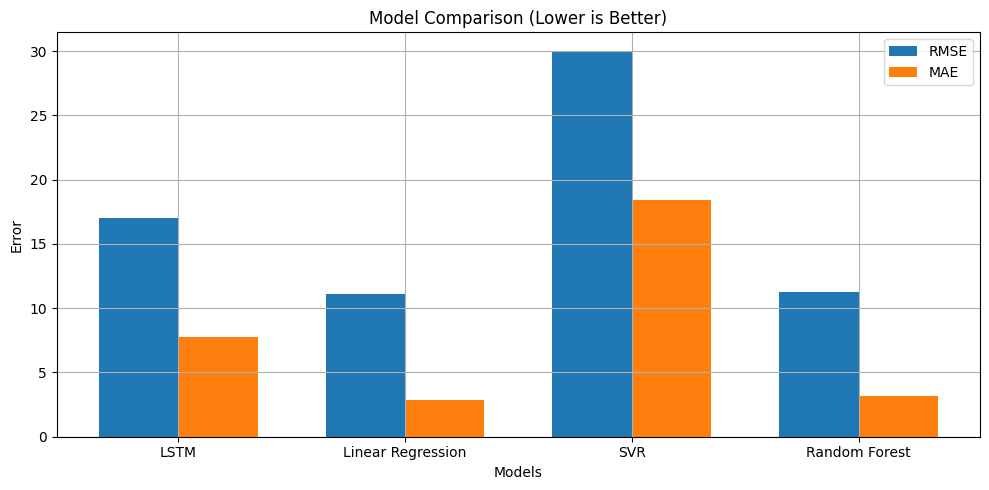


📅 Predicted closing price for tomorrow using Linear Regression: $198.61


In [ ]:
# ✅ Full Stock Price Prediction Script with Multiple Models (Enhanced Version)

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import joblib
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime, timedelta
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Directory setup for saving resources
base_dir = '/content/drive/MyDrive/Stock_Prediction'
os.makedirs(base_dir, exist_ok=True)

# Step 1: User Input
ticker = input("Enter stock ticker symbol (e.g., AAPL): ").upper()

# Step 2: Alpha Vantage API Setup (use your own API key)
api_key = '5L2YFPQK698UM457'
ts = TimeSeries(key=api_key, output_format='pandas')

def safe_download(ticker, retries=5, wait=10):
    for attempt in range(retries):
        try:
            data, meta_data = ts.get_daily(symbol=ticker, outputsize='full')
            print(f"✅ Downloaded {ticker} successfully from Alpha Vantage")
            data.to_csv(os.path.join(base_dir, f"{ticker}_data.csv"))  # Save CSV to drive
            return data['4. close']
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
        time.sleep(wait)
    raise ValueError(f"❌ Failed to download data for {ticker} after {retries} attempts.")

# Step 3: Fetch data
data = safe_download(ticker)
end_date = datetime.today()
start_date = end_date - timedelta(days=365 * 9)

# Step 4: Preprocessing
data = data.sort_index(ascending=True)
data = data.dropna()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

# Step 5: Feature Engineering
look_back = 60
X, y = [], []
for i in range(look_back, len(scaled_data)):
    X.append(scaled_data[i - look_back:i])
    y.append(scaled_data[i])
X, y = np.array(X), np.array(y)

X_train, X_test = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
y_train, y_test = y[:int(0.8*len(y))], y[int(0.8*len(y)):]

# Step 6: LSTM Model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1,
               callbacks=[EarlyStopping(monitor='val_loss', patience=3)], verbose=1)

pred_lstm = lstm_model.predict(X_test)
pred_lstm_rescaled = scaler.inverse_transform(pred_lstm)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 7: Traditional ML Models require reshaping
X_ml = X.reshape(X.shape[0], -1)
X_train_ml, X_test_ml = X_ml[:int(0.8*len(X_ml))], X_ml[int(0.8*len(X_ml)):]

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_ml, y_train)
pred_lr = scaler.inverse_transform(lr.predict(X_test_ml).reshape(-1, 1))

# SVR
svr = SVR(kernel='rbf')
svr.fit(X_train_ml, y_train)
pred_svr = scaler.inverse_transform(svr.predict(X_test_ml).reshape(-1, 1))

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_ml, y_train)
pred_rf = scaler.inverse_transform(rf.predict(X_test_ml).reshape(-1, 1))

# Evaluation Function
def evaluate_model(name, actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    print(f"\n📈 {name} Evaluation")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    return name, rmse, mae

results = []
results.append(evaluate_model("LSTM", y_test_rescaled, pred_lstm_rescaled))
results.append(evaluate_model("Linear Regression", y_test_rescaled, pred_lr))
results.append(evaluate_model("SVR", y_test_rescaled, pred_svr))
results.append(evaluate_model("Random Forest", y_test_rescaled, pred_rf))

# Find best model
best_model = sorted(results, key=lambda x: x[1])[0]  # lowest RMSE
print(f"\n🏆 Best model: {best_model[0]} with RMSE: {best_model[1]:.2f} and MAE: {best_model[2]:.2f}")

# Visualization - Train/Test Data Graphs for all models
# Fixing plotting function to handle dimensions properly
def plot_data_all_models(X, y, title, filename):
    # Reshaping y for correct plotting
    y = y.reshape(-1,)

    plt.figure(figsize=(15, 6))

    # Plotting actual vs predicted values for each model
    plt.plot(y, label='Actual', color='blue')

    # LSTM predictions
    lstm_pred = scaler.inverse_transform(pred_lstm)  # LSTM output
    plt.plot(range(len(X), len(X) + len(lstm_pred)), lstm_pred, label='Predicted LSTM', color='red')

    # Linear Regression predictions
    lr_pred = scaler.inverse_transform(pred_lr)
    plt.plot(range(len(X), len(X) + len(lr_pred)), lr_pred, label='Predicted LR', color='green')

    # SVR predictions
    svr_pred = scaler.inverse_transform(pred_svr)
    plt.plot(range(len(X), len(X) + len(svr_pred)), svr_pred, label='Predicted SVR', color='orange')

    # Random Forest predictions
    rf_pred = scaler.inverse_transform(pred_rf)
    plt.plot(range(len(X), len(X) + len(rf_pred)), rf_pred, label='Predicted RF', color='purple')

    # Title and labels
    plt.title(title)
    plt.xlabel("Days")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save and show plot
    plt.savefig(os.path.join(base_dir, filename))
    plt.show()

# Plot for train data
plot_data_all_models(X_train, y_train, f"Train Data with All Models ({ticker})", f"{ticker}_train_data_all_models.png")

# Plot for test data
plot_data_all_models(X_test, y_test, f"Test Data with All Models ({ticker})", f"{ticker}_test_data_all_models.png")

# Bar Chart Comparison
model_names = [r[0] for r in results]
rmse_scores = [r[1] for r in results]
mae_scores = [r[2] for r in results]

plt.figure(figsize=(10, 5))
bar_width = 0.35
index = np.arange(len(model_names))
plt.bar(index, rmse_scores, bar_width, label='RMSE')
plt.bar(index + bar_width, mae_scores, bar_width, label='MAE')
plt.xlabel('Models')
plt.ylabel('Error')
plt.title('Model Comparison (Lower is Better)')
plt.xticks(index + bar_width / 2, model_names)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(base_dir, f"{ticker}_error_bar_chart.png"))
plt.show()

# Next-Day Forecast with Best Model
if best_model[0] == "LSTM":
    last_60 = scaled_data[-look_back:].reshape(1, look_back, 1)
    next_day_pred = lstm_model.predict(last_60)
    next_day_price = scaler.inverse_transform(next_day_pred)[0][0]
elif best_model[0] == "Linear Regression":
    last_60 = scaled_data[-look_back:].reshape(1, -1)
    next_day_price = scaler.inverse_transform(lr.predict(last_60).reshape(-1, 1))[0][0]
elif best_model[0] == "SVR":
    last_60 = scaled_data[-look_back:].reshape(1, -1)
    next_day_price = scaler.inverse_transform(svr.predict(last_60).reshape(-1, 1))[0][0]
elif best_model[0] == "Random Forest":
    last_60 = scaled_data[-look_back:].reshape(1, -1)
    next_day_price = scaler.inverse_transform(rf.predict(last_60).reshape(-1, 1))[0][0]

print(f"\n📅 Predicted closing price for tomorrow using {best_model[0]}: ${next_day_price:.2f}")


with efficiency

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import joblib
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime, timedelta
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Directory setup for saving resources
base_dir = '/content/drive/MyDrive/Stock_Prediction_f_alpha_vantage'
os.makedirs(base_dir, exist_ok=True)

# Step 1: User Input
ticker = input("Enter stock ticker symbol (e.g., AAPL): ").upper()

# Step 2: Alpha Vantage API Setup
api_key = '5L2YFPQK698UM457'
ts = TimeSeries(key=api_key, output_format='pandas')

def safe_download(ticker, retries=5, wait=10):
    for attempt in range(retries):
        try:
            data, meta_data = ts.get_daily(symbol=ticker, outputsize='full')
            print(f"✅ Downloaded {ticker} successfully from Alpha Vantage")
            data.to_csv(os.path.join(base_dir, f"{ticker}_data.csv"))  # Save CSV to drive
            return data['4. close']
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
        time.sleep(wait)
    raise ValueError(f"❌ Failed to download data for {ticker} after {retries} attempts.")

# Step 3: Fetch data
data = safe_download(ticker)
end_date = datetime.today()
start_date = end_date - timedelta(days=365 * 9)

# Step 4: Preprocessing
data = data.sort_index(ascending=True)
data = data.dropna()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

# Step 5: Feature Engineering
look_back = 60
X, y = [], []
for i in range(look_back, len(scaled_data)):
    X.append(scaled_data[i - look_back:i])
    y.append(scaled_data[i])
X, y = np.array(X), np.array(y)

X_train, X_test = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
y_train, y_test = y[:int(0.8*len(y))], y[int(0.8*len(y)):]

# Step 6: LSTM Model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1,
               callbacks=[EarlyStopping(monitor='val_loss', patience=3)], verbose=1)

pred_lstm = lstm_model.predict(X_test)
pred_lstm_rescaled = scaler.inverse_transform(pred_lstm)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 7: Traditional ML Models require reshaping
X_ml = X.reshape(X.shape[0], -1)
X_train_ml, X_test_ml = X_ml[:int(0.8*len(X_ml))], X_ml[int(0.8*len(X_ml)):]

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_ml, y_train)
pred_lr = scaler.inverse_transform(lr.predict(X_test_ml).reshape(-1, 1))

# SVR
svr = SVR(kernel='rbf')
svr.fit(X_train_ml, y_train)
pred_svr = scaler.inverse_transform(svr.predict(X_test_ml).reshape(-1, 1))

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_ml, y_train)
pred_rf = scaler.inverse_transform(rf.predict(X_test_ml).reshape(-1, 1))

# Evaluation Function with R^2 and Efficiency
def evaluate_model(name, actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    efficiency = 1 / rmse  # Higher efficiency means lower RMSE
    print(f"\n📈 {name} Evaluation")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"R²  : {r2:.2f}")
    print(f"Efficiency: {efficiency:.2f}")
    return name, rmse, mae, r2, efficiency

# Store results
results = []
results.append(evaluate_model("LSTM", y_test_rescaled, pred_lstm_rescaled))
results.append(evaluate_model("Linear Regression", y_test_rescaled, pred_lr))
results.append(evaluate_model("SVR", y_test_rescaled, pred_svr))
results.append(evaluate_model("Random Forest", y_test_rescaled, pred_rf))

# Find best model based on RMSE
best_model = sorted(results, key=lambda x: x[1])[0]  # lowest RMSE
print(f"\n🏆 Best model: {best_model[0]} with RMSE: {best_model[1]:.2f} and MAE: {best_model[2]:.2f}")

# Visualization
plt.figure(figsize=(15, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(pred_lstm_rescaled, label='LSTM')
plt.plot(pred_lr, label='Linear Regression')
plt.plot(pred_svr, label='SVR')
plt.plot(pred_rf, label='Random Forest')
plt.title(f"{ticker} - Actual vs Predicted Closing Prices")
plt.xlabel("Days")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(base_dir, f"{ticker}_all_model_comparison.png"))
plt.show()

# Bar Chart Comparison
model_names = [r[0] for r in results]
rmse_scores = [r[1] for r in results]
mae_scores = [r[2] for r in results]
r2_scores = [r[3] for r in results]
efficiency_scores = [r[4] for r in results]

plt.figure(figsize=(10, 5))
bar_width = 0.35
index = np.arange(len(model_names))
plt.bar(index, rmse_scores, bar_width, label='RMSE')
plt.bar(index + bar_width, mae_scores, bar_width, label='MAE')
plt.bar(index + 2 * bar_width, r2_scores, bar_width, label='R²')
plt.bar(index + 3 * bar_width, efficiency_scores, bar_width, label='Efficiency')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Comparison (Lower is Better for RMSE, MAE, Higher is Better for R² and Efficiency)')
plt.xticks(index + 1.5 * bar_width, model_names)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(base_dir, f"{ticker}_error_bar_chart.png"))
plt.show()

# Next-Day Forecast with Best Model
if best_model[0] == "LSTM":
    last_60 = scaled_data[-look_back:].reshape(1, look_back, 1)
    next_day_pred = lstm_model.predict(last_60)
    next_day_price = scaler.inverse_transform(next_day_pred)[0][0]
elif best_model[0] == "Linear Regression":
    last_60 = scaled_data[-look_back:].reshape(1, -1)
    next_day_price = scaler.inverse_transform(lr.predict(last_60).reshape(-1, 1))[0][0]
elif best_model[0] == "SVR":
    last_60 = scaled_data[-look_back:].reshape(1, -1)
    next_day_price = scaler.inverse_transform(svr.predict(last_60).reshape(-1, 1))[0][0]
elif best_model[0] == "Random Forest":
    last_60 = scaled_data[-look_back:].reshape(1, -1)
    next_day_price = scaler.inverse_transform(rf.predict(last_60).reshape(-1, 1))[0][0]

print(f"\n Predicted closing price for tomorrow using {best_model[0]}: ${next_day_price:.2f}")
